In [241]:
from nnsight import LanguageModel
from typing import List, Callable
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

clear_output()

from nnsight import CONFIG

In [242]:
# Load llama3.1
llama = LanguageModel("meta-llama/Meta-Llama-3.1-8B",device="cuda")
llama

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [243]:
import torch.nn.functional as F
import numpy as np

# run the logit lens on a list of prompts
def run_prompts(model,prompts,target_tokens=None):
    output = zip(
        *[run_lens(model, prompt, target_tokens) for prompt in prompts]
    )
    return output

# run the logit lens on a single prompt, with a list of target tokens
def run_lens(model,PROMPT,target_tokens=None):
    if not target_tokens:
        lens_target_tokens, lens_token_result, lens_token_probs, lens_token_ranks, lens_token_entropy, lens_token_kldiv =logitlens(model,PROMPT)
    
        return [lens_target_tokens], [lens_token_result], [lens_token_probs], [lens_token_ranks], [lens_token_entropy], [lens_token_kldiv]

    
    target_tokens = [torch.tensor(model.tokenizer.encode(target)[1:]) for target in target_tokens]
    lens_target_tokens = []
    lens_token_result = []
    lens_token_probs = []
    lens_token_ranks = []
    lens_token_entropy = []
    lens_token_kldiv = []
    for target_token in target_tokens:
        actual_output, logit_lens_results, logit_lens_all_probs,logit_lens_ranks_by_layer,logit_lens_entropy_by_layer,logit_lens_Kldiv_by_layer= logitlens(model,PROMPT,target_token)
        lens_target_tokens.append(actual_output)
        lens_token_result.append(logit_lens_results)
        lens_token_probs.append(logit_lens_all_probs)
        lens_token_ranks.append(logit_lens_ranks_by_layer)
        lens_token_entropy.append(logit_lens_entropy_by_layer)
        lens_token_kldiv.append(logit_lens_Kldiv_by_layer)

    return lens_target_tokens,lens_token_result,lens_token_probs,lens_token_ranks,lens_token_entropy,lens_token_kldiv

    
# run the logit lens on a single prompt with one target token
def logitlens(model,PROMPT,target_token=None):
    result_by_layer = []
    probs_by_layer = []
    ranks_by_layer = []
    entropy_by_layer = []
    KLdiv_by_layer = []
    input_ids = model.tokenizer.encode(PROMPT)
    with model.trace(input_ids, remote=True) as runner:
        for layer_ix,layer in enumerate(model.model.layers):
            # Get the hidden state for the current layer
            hidden_state = layer.output[0][0]
            logit_lens_normed_last_token = model.model.norm(hidden_state)
            logit_lens_token_distribution = model.lm_head(logit_lens_normed_last_token)
            logit_lens_last_token_logit = logit_lens_token_distribution[-1:]

            # Calculate probabilities using softmax
            logit_lens_probs = F.softmax(logit_lens_last_token_logit, dim=1).save()
            probs_by_layer.append(logit_lens_probs)

            # Get the next token predicted by the model
            logit_lens_next_token = torch.argmax(logit_lens_probs, dim=1).save()
            result_by_layer.append(logit_lens_next_token)
        
        # Get the model's prediction if target_token is not specified
        tokens_out = llama.lm_head.output.argmax(dim=-1).save()
        if target_token is None:
            target_token = tokens_out[0][-1].save()
            
    #get the rank of the expected token from each layer's distribution
    for layer_probs in probs_by_layer:
        # Sort the probabilities in descending order and find the rank of the expected token. 1-based
        sorted_probs, sorted_indices = torch.sort(layer_probs, descending=True)
        expected_token_rank = (sorted_indices == target_token).nonzero(as_tuple=True)[1].item() + 1
        ranks_by_layer.append(expected_token_rank)

        # Calculate entropy for the current layer
        entropy = -(layer_probs * layer_probs.log()).sum(-1).item()
        entropy_by_layer.append(entropy)
        
        # Calculate KL divergence between the current layer and the final layer
        KL_div = (layer_probs * (layer_probs.log()-probs_by_layer[-1].log())).sum(-1).item()
        KLdiv_by_layer.append(KL_div)
    
    # probs_by_layer = np.concatenate([probs[:, target_token].cpu().detach().to(torch.float32).numpy() for probs in probs_by_layer])
    probs_by_layer = np.concatenate([probs[:, target_token].cpu().detach().to(torch.float32).flatten().numpy() for probs in probs_by_layer])

    logit_lens_target = llama.tokenizer.decode(target_token.item())
    results_by_layer = [model.tokenizer.decode(next_token.item()) for next_token in result_by_layer]
    return logit_lens_target,results_by_layer, probs_by_layer,ranks_by_layer,entropy_by_layer,KLdiv_by_layer

In [261]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

def plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_data, plot_type, lower_bound=None, upper_bound=None):
    warnings.filterwarnings("ignore", "Glyph .* missing from font", UserWarning)
    
    plt.figure(figsize=(10, 6))
    lines = [] 

    if plot_type in ['entropy', 'kldiv']:
        logit_lens_data=logit_lens_data[0:1]
        logit_lens_results=logit_lens_results[0:1] if logit_lens_results else None
        if lower_bound is not None and upper_bound is not None:
            lower_bound = lower_bound[0:1]
            upper_bound = upper_bound[0:1]

    for i in range(len(logit_lens_data)):
        item_data = logit_lens_data[i]
        
        if plot_type in ['entropy', 'kldiv']:  # Apply diff_factor if specified
            item_data = np.maximum(item_data, 1e-1)  # e.g., apply log scaling or offset
            
        line, = plt.plot(range(len(item_data)), item_data, marker='x', label=logit_lens_targets[i] if logit_lens_targets else None)
        lines.append(line)
        if lower_bound is not None and upper_bound is not None:
            x = np.arange(len(item_data))
            
            if plot_type in ['entropy', 'kldiv']:  # Apply diff_factor if specified
                lower_bound = np.maximum(lower_bound, 1e-2)  # e.g., apply log scaling or offset
            # Plot the shaded confidence interval
            plt.fill_between(
                x, 
                lower_bound[i],
                upper_bound[i],
                # color='blue', 
                color=line.get_color(),  # Use the color of the line
                alpha=0.2,  # Transparency
                label="95% Confidence Interval"
            )

        if logit_lens_results:
            item_results = logit_lens_results[i]
            for layer_number, next_token in enumerate(item_results):
                plt.text(layer_number, item_data[layer_number], next_token, ha='right', va='bottom')
    
    # Set y-axis scale for entropy and kldiv
    if plot_type in ['entropy', 'kldiv']:
        plt.yscale('log')
    
    # Add legend if targets are provided
    if logit_lens_targets:
        plt.legend(logit_lens_targets,handles=lines)
    
    # Set common labels and title
    plt.xlabel('Layer Number')
    if plot_type == 'probs':
        plt.ylabel('Probability of Target Token')
        plt.title(f'Logit Lens for "{PROMPT}"')
    elif plot_type == 'ranks':
        plt.ylabel('Rank of Target Token')
        plt.title(f'Logit Lens for "{PROMPT}"')
    elif plot_type == 'entropy':
        plt.ylabel('Entropy of Target Token')
        plt.title(f'Logit Lens for "{PROMPT}"')
    elif plot_type == 'kldiv':
        plt.ylabel('KL Divergence of Target Token')
        plt.title(f'Logit Lens for "{PROMPT}"')
    
    plt.grid(True)
    plt.show()


# Running logit lens on a single prompt

In [245]:
PROMPT = "The Eiffel Tower is in "
logit_lens_targets,logit_lens_results, logit_lens_probs,logit_lens_ranks,logit_lens_entropy,logit_lens_kldiv= run_lens(llama,PROMPT,[' Paris',' France'])
# logit_lens_targets,logit_lens_results, logit_lens_probs,logit_lens_ranks,logit_lens_entropy,logit_lens_kldiv= run_lens(llama,PROMPT,[])
# logit_lens_targets,logit_lens_results, logit_lens_probs,logit_lens_ranks,logit_lens_entropy,logit_lens_kldiv = run_lens(llama,PROMPT,[PROMPT.split()[-1]])

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
2024-12-01 19:50:06,830 4703d94b-5acf-4259-969a-a80ed147210a - RECEIVED: Your job has been received and is waiting approval.
2024-12-01 19:50:06,861 4703d94b-5acf-4259-969a-a80ed147210a - APPROVED: Your job was approved and is waiting to be run.
2024-12-01 19:50:06,912 4703d94b-5acf-4259-969a-a80ed147210a - RUNNING: Your job has started running.
2024-12-01 19:50:07,516 4703d94b-5acf-4259-969a-a80ed147210a - COMPLETED: Your job has been completed.
2024-12-01 19:50:08,582 ab6967df-b623-4730-9106-13ff424742d1 - RECEIVED: Your job has been received and is waiting approval.
2024-12-01 19:50:08,612 ab6967df-b623-4730-9106-13ff424742d1 - APPROVED: Your job was approved and is waiting to be run.
2024-12-01 19:50:08,654 ab6967df-b623-4730-9106-13ff424742d1 - RUNNING:

/tmp/ipykernel_214573/1713986702.py:53: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  plt.legend(logit_lens_targets,handles=lines)


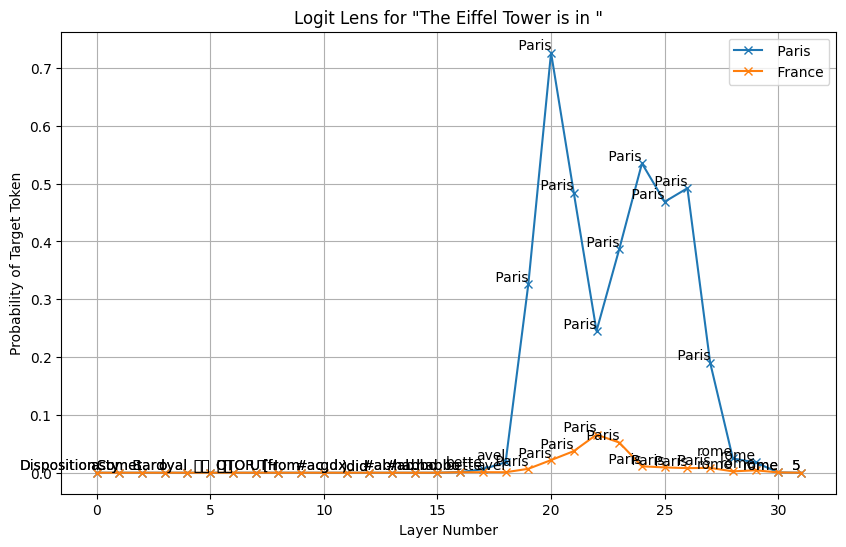

/tmp/ipykernel_214573/1713986702.py:53: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  plt.legend(logit_lens_targets,handles=lines)


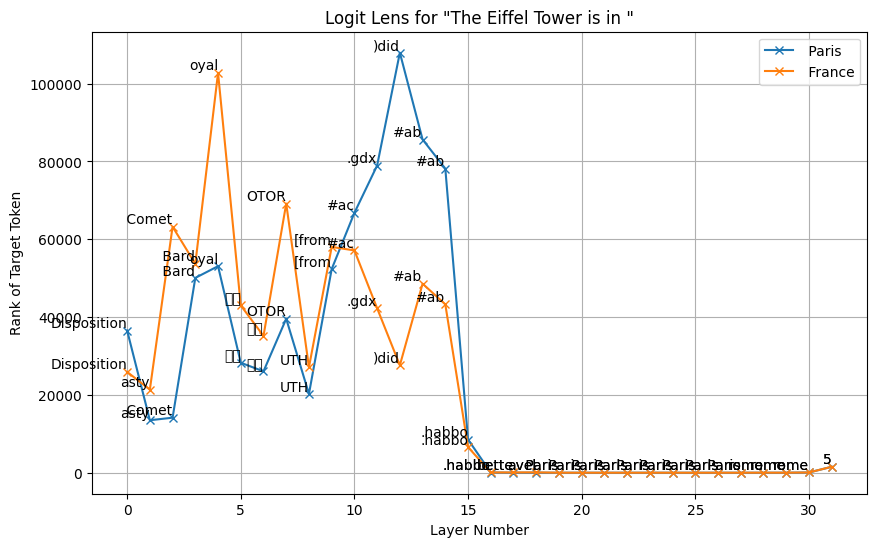

/tmp/ipykernel_214573/1713986702.py:53: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  plt.legend(logit_lens_targets,handles=lines)


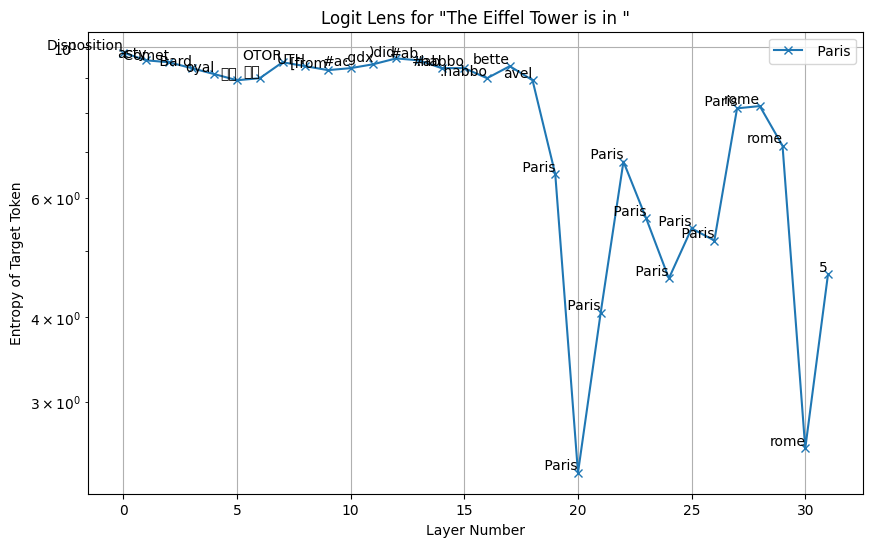

/tmp/ipykernel_214573/1713986702.py:53: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  plt.legend(logit_lens_targets,handles=lines)


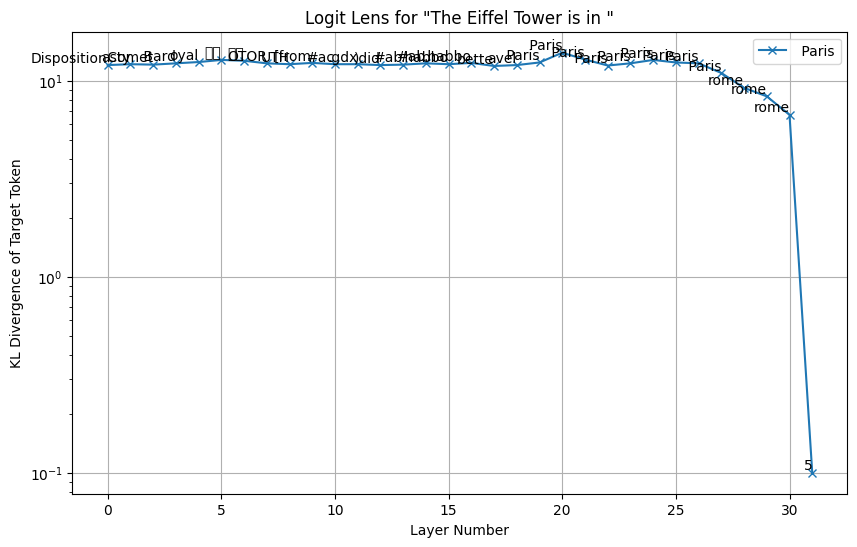

In [256]:
# Example usage
plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_probs, plot_type='probs')
plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_ranks, plot_type='ranks')
plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_entropy, plot_type='entropy')
plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_kldiv, plot_type='kldiv')

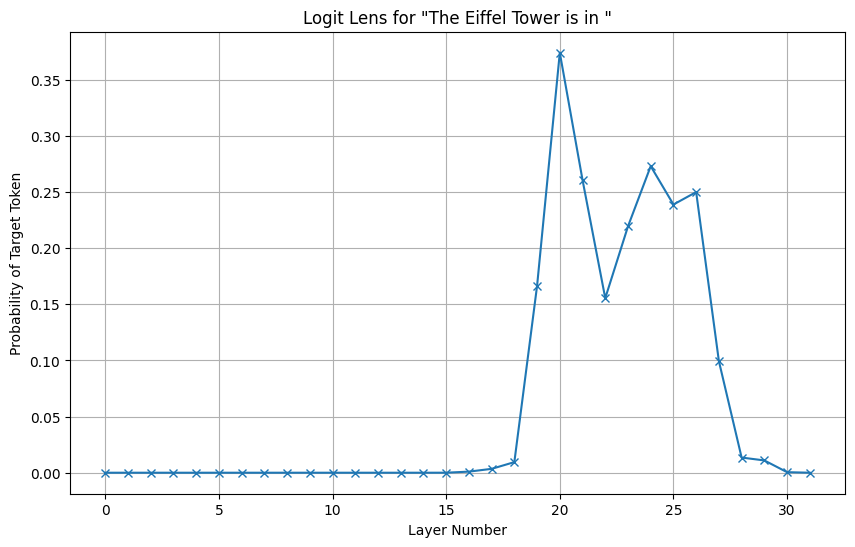

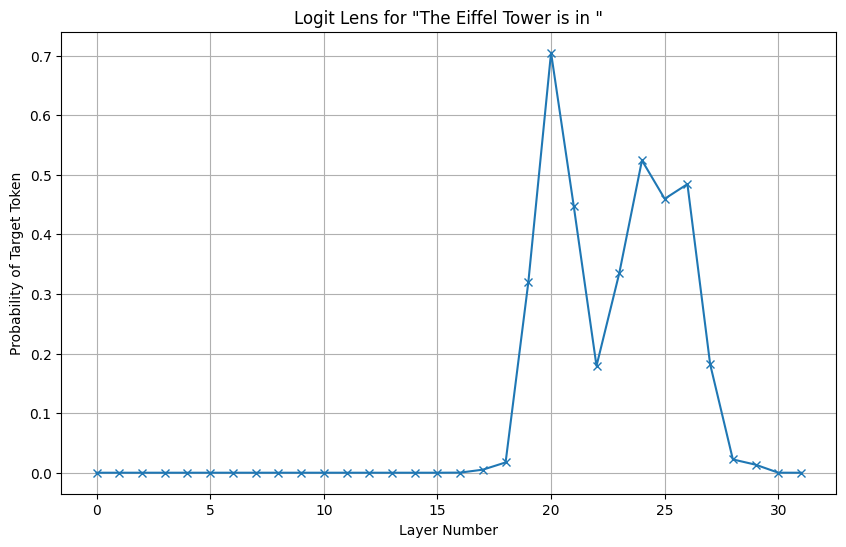

In [257]:
#take the mean 
# print(logit_lens_probs)
mean_probs  = [np.mean(np.stack(logit_lens_probs), axis=0)]
plot_lens(PROMPT,None, None, mean_probs, plot_type='probs')


# #take the difference
diff_probs  = [np.stack(logit_lens_probs)[0] - np.stack(logit_lens_probs)[1]]
diff_ranks = [np.stack(logit_lens_ranks)[0] - np.stack(logit_lens_ranks)[1]]
plot_lens(PROMPT,None, None, diff_probs, plot_type='probs')

# Running logit lens accross a list of prompts

In [258]:
prompts= ["The Eiffel Tower is in the city of ", "Vatican is in the city of "]
prompts_target_tokens, prompts_token_result, prompts_token_probs, prompts_token_ranks, prompts_token_entropy, prompts_token_kldiv = run_prompts(llama,prompts)

2024-12-01 20:05:48,437 5653edca-bac2-41a3-bfd7-aff204ce78a2 - RECEIVED: Your job has been received and is waiting approval.
2024-12-01 20:05:48,475 5653edca-bac2-41a3-bfd7-aff204ce78a2 - APPROVED: Your job was approved and is waiting to be run.
2024-12-01 20:05:48,602 5653edca-bac2-41a3-bfd7-aff204ce78a2 - RUNNING: Your job has started running.
2024-12-01 20:05:49,199 5653edca-bac2-41a3-bfd7-aff204ce78a2 - COMPLETED: Your job has been completed.
2024-12-01 20:05:50,173 b4786919-70ad-4ecd-b8a6-a5061d0b4dd6 - RECEIVED: Your job has been received and is waiting approval.
2024-12-01 20:05:50,203 b4786919-70ad-4ecd-b8a6-a5061d0b4dd6 - APPROVED: Your job was approved and is waiting to be run.
2024-12-01 20:05:50,251 b4786919-70ad-4ecd-b8a6-a5061d0b4dd6 - RUNNING: Your job has started running.
2024-12-01 20:05:50,802 b4786919-70ad-4ecd-b8a6-a5061d0b4dd6 - COMPLETED: Your job has been completed.


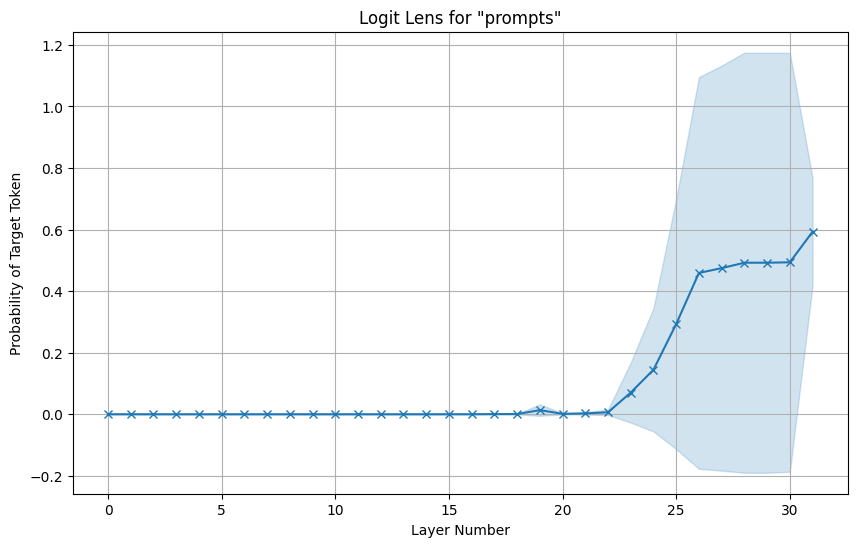

/tmp/ipykernel_214573/4181982281.py:53: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  plt.legend(logit_lens_targets,handles=lines)


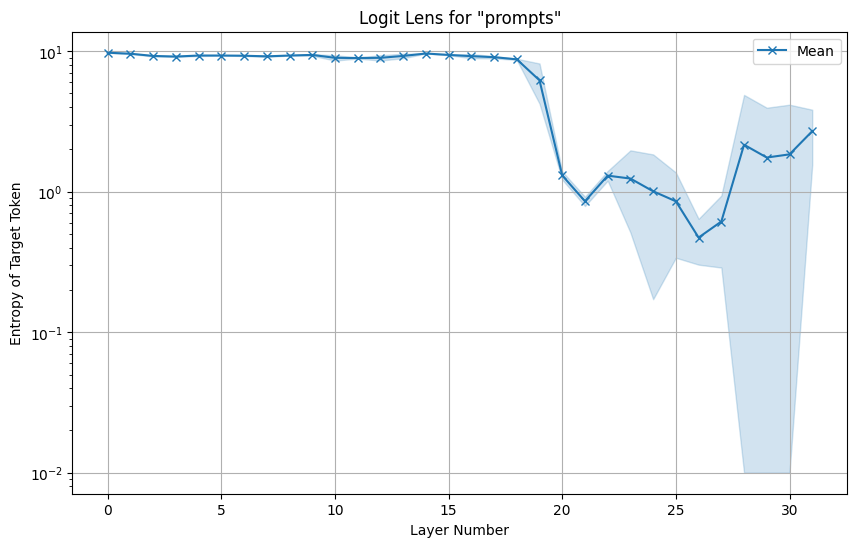

/tmp/ipykernel_214573/4181982281.py:53: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  plt.legend(logit_lens_targets,handles=lines)


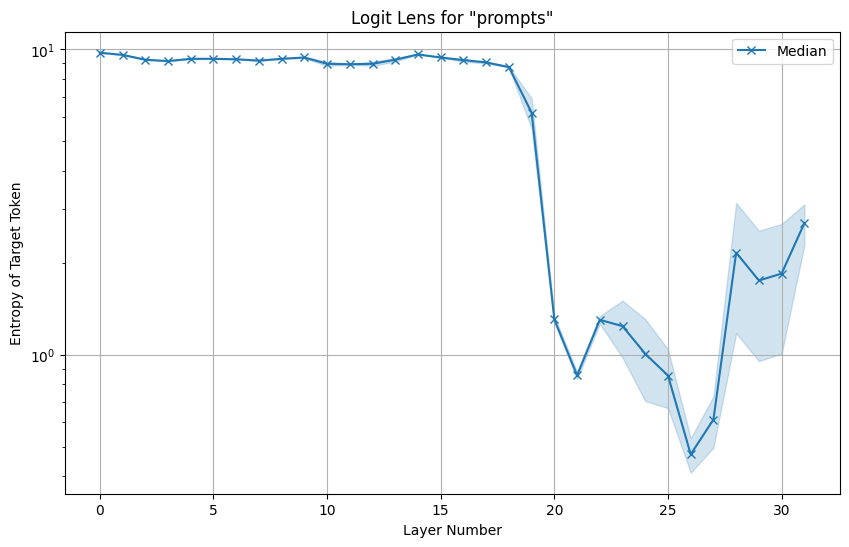

In [263]:
def compute_confidence_interval(logits_stacked, confidence_level=0.95):
    """
    Computes the confidence interval for the logits across all prompts over 32 layers.
    
    Parameters:
    - logits_stacked (np.array): The stacked logits for a token across all prompts (shape: num_prompts x 32).
    - confidence_level (float): The confidence level (default is 0.95).
    
    Returns:
    - lower_bound (np.array): Lower bound of the confidence interval for each layer.
    - upper_bound (np.array): Upper bound of the confidence interval for each layer.
    """
    # Compute the mean and standard deviation across the prompts
    mean_logits = np.mean(logits_stacked, axis=0)  # Mean across prompts for each layer
    std_dev = np.std(logits_stacked, axis=0)  # Standard deviation across prompts for each layer
    num_prompts = logits_stacked.shape[0]  # Number of prompts

    # Compute the standard error of the mean (SEM)
    sem = std_dev / np.sqrt(num_prompts)

    # Z-score for the desired confidence level (e.g., 95% confidence level -> Z ≈ 1.96)
    z_score = 1.96 if confidence_level == 0.95 else 1.64  # 1.64 for 90% confidence

    # Compute the confidence interval (CI)
    margin_of_error = z_score * sem
    lower_bound = mean_logits - margin_of_error
    upper_bound = mean_logits + margin_of_error

    return lower_bound, upper_bound

mean_probs  = np.mean(np.stack(prompts_token_probs), axis=0)
lower_bound, upper_bound = compute_confidence_interval(np.stack(prompts_token_probs))
plot_lens("prompts",None, None, mean_probs, plot_type='probs', lower_bound=lower_bound,upper_bound=upper_bound)

mean_entropy = np.mean(np.stack(prompts_token_entropy), axis=0)
lower_bound, upper_bound = compute_confidence_interval(np.stack(prompts_token_entropy))
plot_lens("prompts",['Mean'], None, mean_entropy, plot_type='entropy', lower_bound=lower_bound,upper_bound=upper_bound)

median_entropy=np.percentile(np.stack(prompts_token_entropy), 50, axis=0)
lower_bound=np.percentile(np.stack(prompts_token_entropy), 25, axis=0)
upper_bound=np.percentile(np.stack(prompts_token_entropy), 75, axis=0)
plot_lens("prompts",['Median'], None, median_entropy, plot_type='entropy', lower_bound=lower_bound,upper_bound=upper_bound)

# Run logits lens across a list of prompts each with multiple target tokens

In [264]:
prompts= ["Is the sky blue on a clear day? ","Do birds migrate during the winter? ","Can a person survive without food for a month? "]
prompts_target_tokens, prompts_token_result, prompts_token_probs, prompts_token_ranks, prompts_token_entropy, prompts_token_kldiv = run_prompts(llama,prompts,["Yes","No"])

2024-12-01 20:07:30,924 8d572237-fe1a-4376-bb0d-5466828bf025 - RECEIVED: Your job has been received and is waiting approval.
2024-12-01 20:07:30,955 8d572237-fe1a-4376-bb0d-5466828bf025 - APPROVED: Your job was approved and is waiting to be run.
2024-12-01 20:07:31,005 8d572237-fe1a-4376-bb0d-5466828bf025 - RUNNING: Your job has started running.
2024-12-01 20:07:31,666 8d572237-fe1a-4376-bb0d-5466828bf025 - COMPLETED: Your job has been completed.
2024-12-01 20:07:32,556 72fc1e1f-bddf-46e4-8c39-63754f46d466 - RECEIVED: Your job has been received and is waiting approval.
2024-12-01 20:07:32,586 72fc1e1f-bddf-46e4-8c39-63754f46d466 - APPROVED: Your job was approved and is waiting to be run.
2024-12-01 20:07:32,631 72fc1e1f-bddf-46e4-8c39-63754f46d466 - RUNNING: Your job has started running.
2024-12-01 20:07:33,260 72fc1e1f-bddf-46e4-8c39-63754f46d466 - COMPLETED: Your job has been completed.
2024-12-01 20:07:33,869 2e6b1527-8e0b-4276-a1ad-8488b90c5353 - RECEIVED: Your job has been receive

prompts_token_probs is a list of lists, where each inner list is the results from runninng a prompt. Each prompt result is a list with two np array inside, with the first nparray represents token "Yes" and second nparray represent token"No". I want to average all the prompts first nparray, acrross the 32 layers. and then do the same for the second nparray. So the result should be a list of two nparray, where the first nparray is the averaged logits porb for token "yes" on 32 layers, and the second nparray is for 'no'.

/tmp/ipykernel_214573/4181982281.py:53: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  plt.legend(logit_lens_targets,handles=lines)


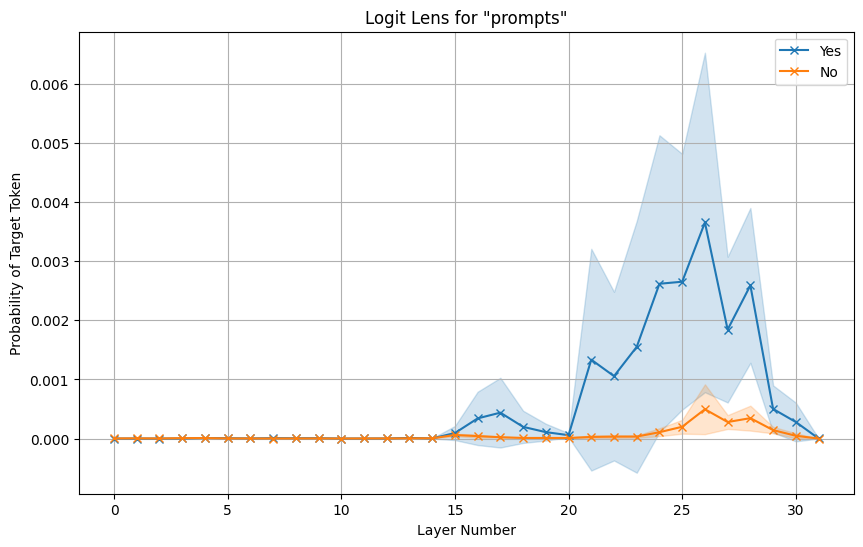

/tmp/ipykernel_214573/4181982281.py:53: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  plt.legend(logit_lens_targets,handles=lines)


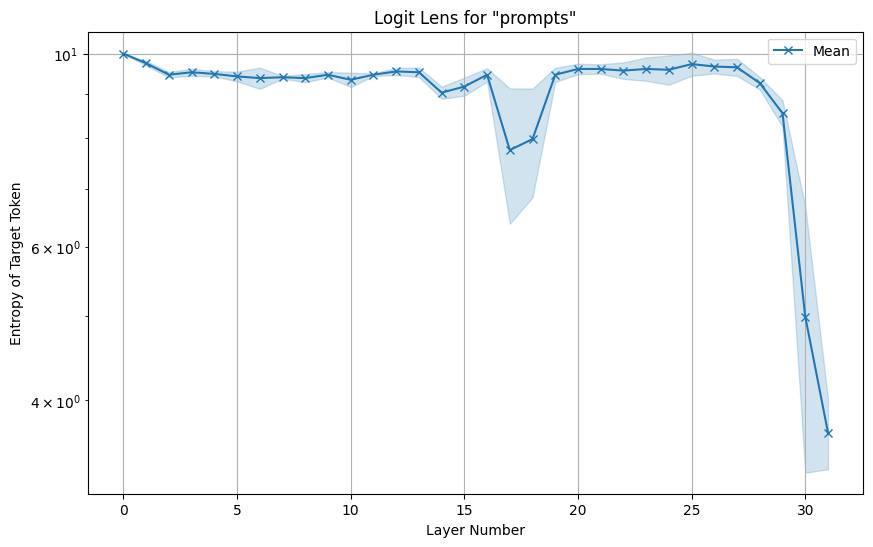

In [268]:
import numpy as np
def average_logits_by_token(all_prompts_results):
    # Extract logits for "Yes" and "No" from each prompt
    yes_logits = [result[0] for result in all_prompts_results]  # "Yes" logits for each prompt
    no_logits = [result[1] for result in all_prompts_results]   # "No" logits for each prompt

    # Stack logits for each token across all prompts
    yes_logits_stacked = np.stack(yes_logits)  # Shape: (num_prompts, 32)
    no_logits_stacked = np.stack(no_logits)    # Shape: (num_prompts, 32)

    # Compute the average logits (mean across prompts)
    avg_yes_logits = np.mean(yes_logits_stacked, axis=0)  # Mean across prompts for each layer
    avg_no_logits = np.mean(no_logits_stacked, axis=0)    # Mean across prompts for each layer
    avg_logits = [avg_yes_logits, avg_no_logits]

    # Compute the confidence intervals for each token
    ci_yes_lower, ci_yes_upper = compute_confidence_interval(yes_logits_stacked)
    ci_no_lower, ci_no_upper = compute_confidence_interval(no_logits_stacked)

    ci_lower = [ci_yes_lower, ci_no_lower]
    ci_upper = [ci_yes_upper, ci_no_upper]

    return avg_logits, ci_lower, ci_upper

prompts_target_token = prompts_target_tokens[0]
mean_probs,lower_bound,upper_bound  = average_logits_by_token(prompts_token_probs)
plot_lens("prompts",prompts_target_token, None, mean_probs, plot_type='probs', lower_bound=lower_bound,upper_bound=upper_bound)

mean_entropy,lower_bound,upper_bound  = average_logits_by_token(prompts_token_entropy)
plot_lens("prompts",['Mean'], None, mean_entropy, plot_type='entropy', lower_bound=lower_bound,upper_bound=upper_bound)